# **Problem Statement**

The dataset consists of two folders, train and test. The train folder is subdivided into 10 subfolders, each containing 1,000 images and the name of these subfolders is the label of the respective class. For the test folder, all 2,000 images are in a single folder. Your task is to predict the labels of these images.

Note: Use the following mapping for submitting labels:-

Amphibia - 0
Animalia - 1
Arachnida - 2
Aves - 3
Fungi - 4
Insecta - 5
Mammalia - 6
Mollusca - 7
Plantae - 8
Reptilia - 9

In [57]:
pip install torch torchvision timm

Note: you may need to restart the kernel to use updated packages.


In [58]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


# **Loading the Packages**

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as dsets
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np 
import time
import os
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from torch.utils.data import random_split

import timm #Efficient Net Model

torch.manual_seed(0)

# **Preprocessing the Images**

In [54]:
# Define the transformations
# Resize the input image to match the expected size of EfficientNet (224x224).
# Convert the image to a tensor, so it can be used in PyTorch operations.
# Normalize the image data to match the distribution of the ImageNet dataset, which the pretrained EfficientNet model was trained on.
# These transformations ensure the input images are compatible with the pretrained EfficientNet model for tasks like classification or feature extraction.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match EfficientNet's input size
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize for ImageNet
])


In [55]:
# This class provides a simple way to:
# Load images from a directory.
# Apply transformations to the images.
# Return both the transformed images and their corresponding file paths for further processing.

class TestDataset(Dataset):
    def __init__(self, root, transform = None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, fname) for fname in os.listdir(root) if fname.endswith(('.png','.jpg','.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self,idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, img_path


# **Loading the Data**

In [56]:
train_data = datasets.ImageFolder(root='/kaggle/input/deep-learning-practice-image-classification/train', transform=transform)

In [57]:
test_data = TestDataset('/kaggle/input/deep-learning-practice-image-classification/test', transform = transform)

In [58]:
len(train_data),type(train_data)

(9999, torchvision.datasets.folder.ImageFolder)

In [59]:
num_classes = len(train_data.classes)
num_classes

10

# **Creation of Train and Validation Splits**

In [60]:
train_size = int(0.8*len(train_data))
val_size = len(train_data)-train_size 
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

In [61]:
len(train_dataset), len(val_dataset)

(7999, 2000)

In [62]:
label_map = {idx: label for idx, label in enumerate(train_data.classes)}
print("Label map:", label_map)


Label map: {0: 'Amphibia', 1: 'Animalia', 2: 'Arachnida', 3: 'Aves', 4: 'Fungi', 5: 'Insecta', 6: 'Mammalia', 7: 'Mollusca', 8: 'Plantae', 9: 'Reptilia'}


# **Showing a Sample Image**

In [63]:
def inverse_normalize(tensor, mean, std):
    """
    Inverses the normalization of a tensor for visualization.
    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

def show_image(data, idx, label_map):
    '''
    Function: Displays a single image from the dataset
    
    Inputs:
    - data: dataset (e.g., ImageFolder or CIFAR-10 dataset)
    - idx: index of the image in the dataset
    - label_map: mapping of label indices to class names
    
    Returns:
    - Displays the original and transformed images side by side
    '''
    # Retrieve image and label
    transformed_image, label = data[idx]  # For datasets like ImageFolder or CIFAR-10
    
    # Inverse normalize the image for display
    transformed_image = inverse_normalize(
        transformed_image, 
        mean=[0.491, 0.482, 0.447],  # CIFAR-10 mean
        std=[0.247, 0.244, 0.262]   # CIFAR-10 std
    )
    
    # Convert the tensor to an image format (H, W, C)
    transformed_image = transformed_image.permute(1, 2, 0).clamp(0, 1)  # Ensure values are in [0, 1]
    
    # Plot the transformed image
    plt.figure(figsize=(5, 5))
    plt.imshow(transformed_image)
    plt.title(f'Transformed: {label_map[label]}')
    plt.axis('off')  # Hide axes
    plt.show()

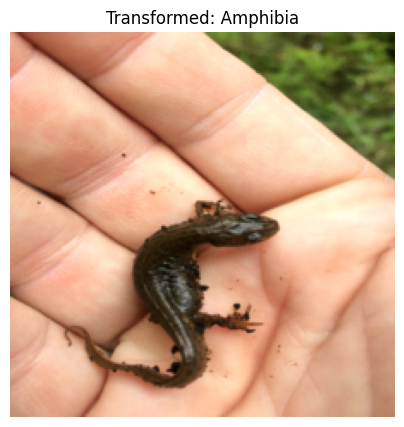

In [64]:
idx = 3
show_image(train_data, idx, label_map)

# **Creation of Batch size and Train & Test Loaders**

In [65]:
# Define the batch size for training and validation
batch_size = 128  # Number of samples to process in each batch

# Create a DataLoader for the training dataset
train_loader = DataLoader(
    train_dataset,           # The dataset to load (training data)
    batch_size=batch_size,   # Number of samples per batch
    shuffle=True             # Shuffle the dataset to randomize input order for training
)

# Create a DataLoader for the validation dataset
val_loader = DataLoader(
    val_dataset,             # The dataset to load (validation data)
    batch_size=batch_size,   # Number of samples per batch
    shuffle=False            # No shuffling for validation data to ensure consistency in evaluation
)


print(f'Classes: {train_data.classes}')

Classes: ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


In [66]:
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

In [67]:
print(len(train_loader.dataset))

7999


torch.Size([128, 3, 224, 224])


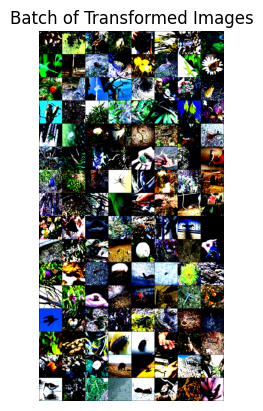

In [68]:
# Getting the first batch in training dataset
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)

# Plotting the first batch
plt.imshow(utils.make_grid(images).permute(1, 2, 0))
plt.title('Batch of Transformed Images')
plt.axis('off')
plt.show()

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [71]:
# Define the number of classes in the dataset
num_classes = 10  # Replace with the actual number of classes in your dataset

# Load a pre-trained EfficientNet model
model = timm.create_model('efficientnet_b0', pretrained=True)
# EfficientNet-B0 is a lightweight convolutional neural network architecture. 
# The model is pre-trained on ImageNet, providing a strong starting point for transfer learning.

# Modify the classifier layer to match the number of classes in the dataset
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Add Dropout with a 50% probability to reduce overfitting
    nn.Linear(model.classifier.in_features, num_classes)  
    # Replace the original classification layer with a fully connected layer.
    # The input size (in_features) is preserved, while the output size is set to `num_classes`.
)

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Use CUDA if available; otherwise, fallback to CPU for model training and inference.

# Move the model to the selected device (GPU or CPU)
model.to(device)  # Ensures the model and data reside on the same device for efficient computation.


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

# **Loss Function, Optimizer & Model Training**

In [73]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [74]:
# Training loop
epochs = 6
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct / total:.2f}%")


Epoch 1/6, Loss: 1.9429961424025277, Accuracy: 38.19%
Epoch 2/6, Loss: 1.0551715805417015, Accuracy: 69.72%
Epoch 3/6, Loss: 0.6222532561847142, Accuracy: 81.17%
Epoch 4/6, Loss: 0.3890748109136309, Accuracy: 88.69%
Epoch 5/6, Loss: 0.23769382541141812, Accuracy: 93.31%
Epoch 6/6, Loss: 0.13556219992183505, Accuracy: 96.65%


In [78]:
# Validation loop
model.eval()
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        val_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total:.2f}%")


Validation Loss: 0.6614161971956491, Accuracy: 80.60%


In [79]:
torch.save(model.state_dict(), "efficientnet_b0.pth")

# **Loading the Test Data**

In [89]:
#on test data
model.eval()
predictions = []
with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        for img_name, label in zip(img_names, predicted.cpu().numpy()):
            # print(img_name.split('/')[5].split('.')[0])
            predictions.append({'Image_ID':img_name.split('/')[5].split('.')[0], 'Label':int(label)})

In [90]:
import pandas as pd
submission_df = pd.DataFrame(predictions)
submission_df.to_csv('submision.csv', index = False)

In [91]:
submission_df.head()

,Image_ID,Label
0,Image_0612,5
1,Image_0946,4
2,Image_0755,8
3,Image_0178,2
4,Image_1593,5
